## DQN - Using a Target Network
Since action-values are used to compute targets, there could be a correlation between them and this correlation could cause problems when a function approximator is used for Q-learning. To solve this problem, Mnih et al have proposed the use of 2 networks: an online network for selecting actions to execute and a target network for evaluation actions and computing targets. Both networks start out with the same parameters but the target network is periodically updated with the values of the online network and held fixed between individual updates.

To see the effect of using a target network, the Agent class has been extended with the update_target() method which clones the online network into the target network. It's predict method also has a new parameter to determine if to use the online or target network to compute action values. Finally, the train method has been updated to make use of the target network when evaluating actions to compute the targets. Everything else is the same as in the original Q-learning notebook. Finally, we visualize the learning of both methods and then evaluate them.

In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gym
import cntk
from cntk import *
from cntk.layers import *
%matplotlib inline

In [2]:
class Agent:
    def __init__(self, state_dim, action_dim, learning_rate):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.learning_rate = learning_rate
        self.epsilon = 1
        
        # Create the model and set up trainer
        self.state_var = input(self.state_dim, np.float32)
        self.action_var = input(self.action_dim, np.float32)
        
        self.online_model = Sequential([
            Dense(64, activation=relu),
            Dense(self.action_dim)
        ])(self.state_var)

        loss = reduce_mean(square(self.online_model - self.action_var), axis=0)
        lr_schedule = learning_rate_schedule(self.learning_rate, UnitType.sample)
        learner = sgd(self.online_model.parameters, lr_schedule)
        self.trainer = Trainer(self.online_model, loss, learner)
        
        # Create target network and initialize with same weights
        self.target_model = None
        self.update_target()
    
    def update_target(self):
        """
        Updates the target network using the online network weights
        """
        self.target_model = self.online_model.clone(CloneMethod.clone)
        
    def update_epsilon(self, episode):
        """
        Updates epsilon using exponential decay with the decay rate chosen such
        that epsilon is 0.05 by episode 8000
        """
        self.epsilon = max(math.exp(-3.74e-4 * episode), 0.05)
        
    def predict(self, s, target=False):
        """
        Feeds a state through the model (our network) and obtains the values of each action
        """
        if target:
            return self.target_model.eval(s)[0]
        else:
            return self.online_model.eval(s)[0]
        
    def act(self, state):
        """
        Selects an action using the epoch-greedy approach
        """
        prob = np.random.randn(1)
        if prob > self.epsilon:
            # exploit (greedy)
            return np.argmax(self.predict(state))
        else:
            # explore (random action)
            return np.random.randint(0, self.action_dim)
        
    def train(self, x, y):
        """
        Performs a single gradient descent step using the provided states and targets
        """
        self.trainer.train_minibatch({self.state_var: x, self.action_var: y})
        
    def evaluate(self, env, n):
        """
        Computes the average performance of the trained model over n episodes
        """
        episode = 0
        rewards = 0
        while episode < n:
            s = env.reset()
            done = False
            while not done:
                a = np.argmax(self.predict(s.astype(np.float32)))
                s, r, done, info = env.step(a)
                rewards += r
            episode += 1
            
        return rewards / float(n)

In [8]:
def train(env, agent, episodes, gamma, update_freq, use_target=True):
    """
    param env: The gym environment to train with
    param agent: The agent to train
    param episodes: The number of episodes to train for
    param gamma: The discount factor
    param update_freq: The frequency at which to update the target network
    param use_target: If true, uses the target network for state evaluation
    """    
    episode = 0
    rewards = 0
    log_freq = 200
    episode_rewards = []
    s = env.reset().astype(np.float32)
    
    while episode < episodes:
        # Select action using policy derived from Q (e-greedy) 
        a = agent.act(s)

        # Take action and observe next state and reward
        s_, r, done, info = env.step(a)
        s_ = s_.astype(np.float32)
        
        # Compute target, y_i
        y = agent.predict(s)
        
        if use_target:
            q_next = agent.predict(s_, target=True)
        else:
            q_next = agent.predict(s_)
        
        if done:
            y[a] = r
        else:
            y[a] = r + gamma * np.amax(q_next)

        # Train using state and computed target
        agent.train(s, y)

        s = s_
        rewards += r

        if done:
            # Episode over, reset environment
            episode_rewards.append(rewards)
            rewards = 0
            
            episode += 1
            agent.update_epsilon(episode)
            s = env.reset().astype(np.float32)
            
            if episode % log_freq == 0:
                ave = sum(episode_rewards[(episode - log_freq):]) / float(log_freq)
                print('Episode = {}, Average rewards = {}'.format(episode, ave))
                
            if episode % update_freq == 0 and use_target:
                agent.update_target()
                
    return episode_rewards

In [4]:
gamma = 0.60
learning_rate = 0.00025
episodes = 10000
update_freq = 500

In [5]:
env = gym.make('CartPole-v0')
state_dim = env.observation_space.shape
action_dim = env.action_space.n

[2017-04-21 14:30:26,451] Making new env: CartPole-v0


In [6]:
agent1 = Agent(state_dim, action_dim, learning_rate)
rewards1 = train(env, agent1, episodes, gamma, update_freq, use_target=False)

Episode = 200, Average rewards = 17.615
Episode = 400, Average rewards = 16.215
Episode = 600, Average rewards = 16.74
Episode = 800, Average rewards = 17.435
Episode = 1000, Average rewards = 17.235
Episode = 1200, Average rewards = 16.25
Episode = 1400, Average rewards = 16.88
Episode = 1600, Average rewards = 17.145
Episode = 1800, Average rewards = 18.07
Episode = 2000, Average rewards = 19.115
Episode = 2200, Average rewards = 18.315
Episode = 2400, Average rewards = 19.615
Episode = 2600, Average rewards = 20.24
Episode = 2800, Average rewards = 24.73
Episode = 3000, Average rewards = 27.205
Episode = 3200, Average rewards = 31.15
Episode = 3400, Average rewards = 31.14
Episode = 3600, Average rewards = 31.455
Episode = 3800, Average rewards = 31.98
Episode = 4000, Average rewards = 34.35
Episode = 4200, Average rewards = 34.84
Episode = 4400, Average rewards = 37.13
Episode = 4600, Average rewards = 32.305
Episode = 4800, Average rewards = 39.025
Episode = 5000, Average rewards 

In [9]:
agent2 = Agent(state_dim, action_dim, learning_rate)
rewards2 = train(env, agent2, episodes, gamma, update_freq)

Episode = 200, Average rewards = 19.785
Episode = 400, Average rewards = 21.415
Episode = 600, Average rewards = 19.55
Episode = 800, Average rewards = 20.515
Episode = 1000, Average rewards = 19.145
Episode = 1200, Average rewards = 18.355
Episode = 1400, Average rewards = 17.74
Episode = 1600, Average rewards = 20.245
Episode = 1800, Average rewards = 16.93
Episode = 2000, Average rewards = 17.865
Episode = 2200, Average rewards = 17.02
Episode = 2400, Average rewards = 17.26
Episode = 2600, Average rewards = 22.485
Episode = 2800, Average rewards = 35.36
Episode = 3000, Average rewards = 23.465
Episode = 3200, Average rewards = 18.21
Episode = 3400, Average rewards = 17.035
Episode = 3600, Average rewards = 16.23
Episode = 3800, Average rewards = 17.92
Episode = 4000, Average rewards = 33.605
Episode = 4200, Average rewards = 47.395
Episode = 4400, Average rewards = 51.015
Episode = 4600, Average rewards = 49.67
Episode = 4800, Average rewards = 51.255
Episode = 5000, Average reward

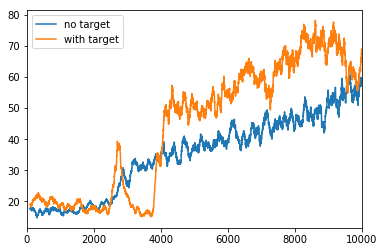

In [10]:
pd.Series(rewards1).rolling(window=100).mean().plot(label='no target')
pd.Series(rewards2).rolling(window=100).mean().plot(label='with target')
plt.legend()
plt.show()

In [11]:
eval_episodes = 100
ave_without = agent1.evaluate(env, eval_episodes)
ave_with = agent2.evaluate(env, eval_episodes)

print('Average (without target network) = {}'.format(ave_without))
print('Average (with target network) = {}'.format(ave_with))

Average (without target network) = 89.33
Average (with target network) = 123.56


### References
[1] Volodymyr M., Koray K., David S., Alex G., Ioannis A., Daan W. & Martin R. Playing Atari with Deep Reinforcement Learning. ArXiv:1312.5602